In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lib.fit_model_on_multiple import fit_lr, predict_lr, fit_rf, plot_md_vs_rmsd, predict_rf
from pathlib import Path
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path
from scipy.stats import linregress, pearsonr

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
Slope: -1.077774867148758, Intercept: 74.80392248148382 R-squared: 0.5579562098725406


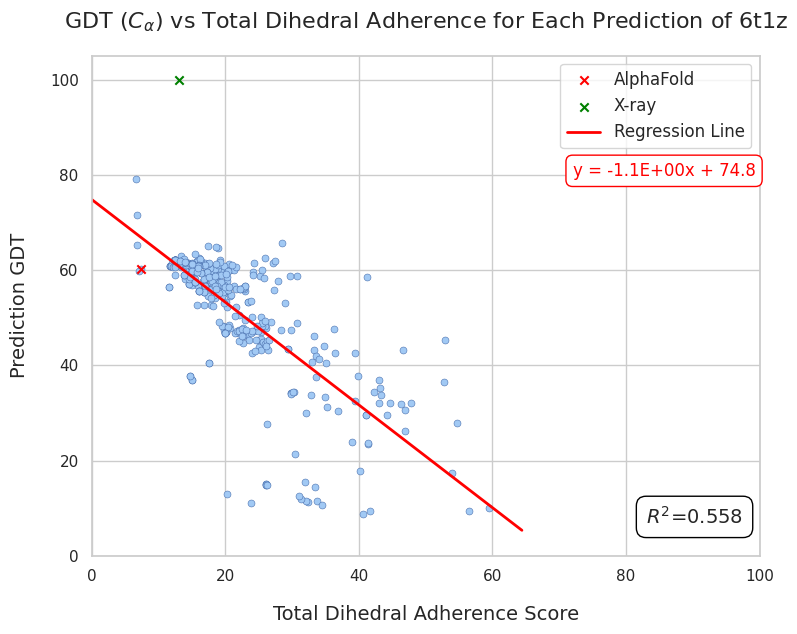

In [43]:
mds = []
rmsds = []
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']

da = DihedralAdherence(
    proteins[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml',
    weights_file='ml_data/best_model-kde_16-32_383.pt', device='cuda'
)
da.load_results_da()
da.filter_nas(0.8)
da.plot_da_vs_gdt_simple()

(3, 100)

In [55]:
y_pred.shape

(3, 100)

0.5688358439706107


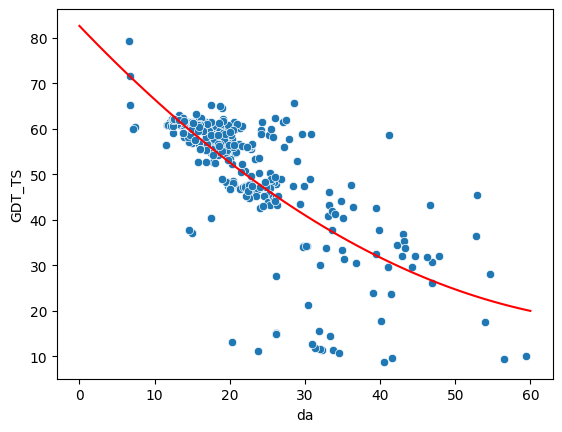

In [58]:
# da.grouped_preds['GDT_TS'] = np.log10(da.grouped_preds['GDT_TS'])
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures

degree = 2
poly = PolynomialFeatures(degree)
X = poly.fit_transform(da.grouped_preds[['da']]) # X is [1, da, da^2] for each da
y = da.grouped_preds['GDT_TS']
model = OLS(y, X).fit()

x = np.linspace(0, 60, 100)
x = np.stack([np.ones_like(x), x, x**2]).T
y_pred = model.predict(x)
print(model.rsquared)

sns.scatterplot(x=da.grouped_preds['da'], y=da.grouped_preds['GDT_TS'])
plt.plot(x[:,1], y_pred, color='red')
plt.show()

In [12]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
# proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']
proteins = [
    'T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
    # 'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]

preds = []
for protein in proteins:
    da = DihedralAdherence(
        protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml',
        weights_file='ml_data/best_model-kde_16-32_383.pt', device='cuda'
    )
    da.load_results_da()
    da.filter_nas(.8)
    preds.append(da.grouped_preds)

preds = pd.concat(preds)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
Initializing T1096 ...
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
No prediction found in AlphaFold DB for 7um1
No AlphaFold phi-psi data found
Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found
Initializing T1030 ...
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
Initializing T1038 ...
Results already exist
Casp ID: T1038 	PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
No prediction found in AlphaFold DB for 6ya2
No AlphaFold phi-psi data found
Initializing T1030-D2 ...
Results already exist
Casp ID: T1030-D2 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
No CASP AlphaFold prediction
Initializing T1024-D1 ...
Results already exist
Casp ID: T1024-D1 	PDB: 6t1z
Structure exists: 'p

In [13]:
preds_orig = preds.copy()

0.5167800919955106 PearsonRResult(statistic=-0.7188741837035952, pvalue=0.0)
Slope: -58.171687462654695, Intercept: 131.16093465967293


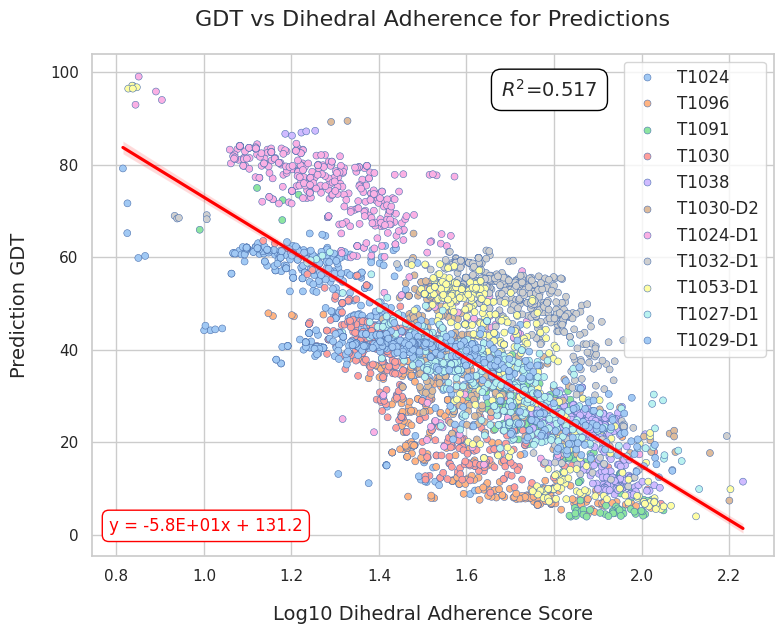

In [71]:
sns.set_theme(style="whitegrid")
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(8, 6.5))
df = preds.dropna(subset=['da', 'GDT_TS']).reset_index(drop=True)

df['da'] = np.log10(df['da'])
# df['GDT_TS'] = np.log10(df['GDT_TS'])

# df = df[df.GDT_TS < 20]
regr = linregress(df.da, df.GDT_TS)
corr = pearsonr(df['da'], df['GDT_TS'])
print(regr.rvalue**2, corr)
print(f'Slope: {regr.slope}, Intercept: {regr.intercept}')
# sns.kdeplot(data=df, x='da', y='GDT_TS', ax=ax, fill=True, bw_method=0.1)
sns.scatterplot(data=df, x='da', y='GDT_TS', ax=ax, marker='o', s=25, edgecolor='b', legend=True, hue='target', palette='pastel')
sns.regplot(data=df.reset_index(drop=True), x='da', y='GDT_TS', ax=ax, scatter=False, color='red')
# ax.plot(
#     np.linspace(0, preds.da.max() + 5, 100), 
#     regr.intercept + regr.slope * np.linspace(0, preds.da.max() + 5, 100), 
#     color='red', lw=2, label='Regression Line'
# )
ax.set_xlabel('Log10 Dihedral Adherence Score', fontsize=14, labelpad=15)
ax.set_ylabel('Prediction GDT', fontsize=14, labelpad=15)
ax.set_title(r'GDT vs Dihedral Adherence for Predictions', fontsize=16, pad=20)
ax.text(0.6, 0.95, r'$R^2$='+f'{regr.rvalue**2:.3f}', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))
if regr.intercept > 0:
    s = f'y = {regr.slope:.1E}x + {regr.intercept:.1f}'
else:
    s = f'y = {regr.slope:.1E}x - {-regr.intercept:.1f}'
ax.text(.025,.05, s, transform=ax.transAxes, fontsize=12, color='red',
        bbox=dict(boxstyle='round,pad=0.4', edgecolor='red', facecolor='white'))
# ax.set_xlim(0, preds.da.max() + 5)
# ax.set_ylim(-0.5, preds.RMS_CA.max() + 5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
sns.reset_defaults()

In [17]:
results = []
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']
total_samples = 0
for protein in proteins:
    da = DihedralAdherence(protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,32,64,128], 
                           mode='ml', weights_file='ml_data/best_model-kde_16-32_383.pt', device='cuda')

    da.load_results_da()
    da.filter_nas(quantile=0.8)
    n_preds = da.grouped_preds_da.shape[0]
    total_samples += n_preds
    rsquared, pearsonr = da.test_correlation()
    results.append((protein, rsquared, pearsonr, n_preds))
results = pd.DataFrame(results, columns=['protein', 'rsquared', 'pearsonr', 'n_preds'])
results.loc[len(results)] = ['Mean', results.rsquared.mean(), results.pearsonr.mean(), results.n_preds.mean()]
print(total_samples)
results.to_markdown('thisresult.md',index=False)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
LinRegr - Slope: -1.077774867148758, Intercept: 74.80392248148382 R-squared: 0.5579562098725406 p-value: 1.0478612175260064e-69
Pearson Correlation: -0.7469646644069181, p-value: 1.0478612175263659e-69
Initializing T1096 ...
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
No AlphaFold prediction found for 7um1
No AlphaFold phi-psi data found
LinRegr - Slope: -0.4926539299386467, Intercept: 42.0259181346802 R-squared: 0.5115809481987071 p-value: 1.7783790033423793e-55
Pearson Correlation: -0.7152488715116639, p-value: 1.7783790033412375e-55
Initializing T1091 ...
Results already exist
Casp ID: T1091 	PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
No UniProt mapping found for 7w6b
No AlphaFold phi-psi data found
LinRegr - Slope: -0.5516612205315455, Intercept: 56.90078719925352 R-squared: 0.7098913249235055 p-value: 3.1940649076565312e-84
Pearso

In [ ]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1091', 'T1030', 'T1038', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1']

af_scores = []
rsquareds = []
for protein in proteins:
    da = DihedralAdherence(
        protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml',
        weights_file='ml_data/best_model-kde_16-32_383.pt', device='cuda'
    )
    da.load_results_da()
    da.filter_nas(.8)
    if da.alphafold_id in da.grouped_preds.protein_id.values:
        af_scores.append(da.grouped_preds[da.grouped_preds.protein_id == da.alphafold_id].da.values[0])
        rsquared, pearsonr = da.test_correlation()
        rsquareds.append(rsquared)

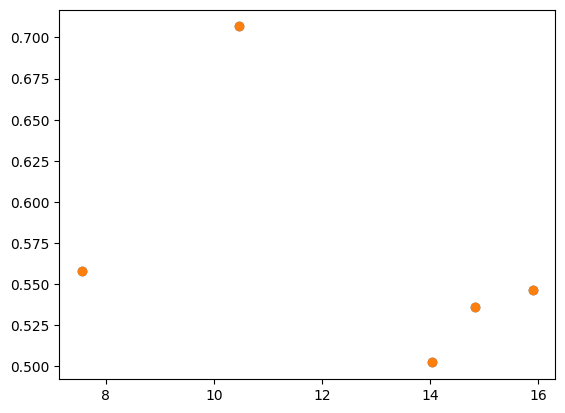

In [14]:
plt.scatter(af_scores, rsquareds)
plt.show()